In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns

sns.set_style("white")

plt.rcParams['figure.figsize'] = 20,10

In [82]:
data_train = pd.read_csv("../OriginalData/training_input.csv",sep = ";")
target_train = pd.read_csv("../OriginalData/training_output.csv", sep = ";")
data_test = pd.read_csv("../OriginalData/testing_input.csv",sep = ";")

# Let's try to use "correlated" products to make new predictions

In [67]:
data_train["TARGET"] = target_train["TARGET"]
data_train.head()

,ID,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,...,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00,TARGET
0,1,1,1,0.662737,0.716896,0.698601,0.480172,0.623665,0.201876,0.327206,...,1.0,1.0,-1.0,1.0,-1.0,0.0,1.0,1.0,-1.0,0.134168
1,2,1,2,0.285394,0.379560,0.094858,0.094794,0.055315,0.173994,0.102745,...,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,0.046126
2,3,1,3,1.151646,1.093562,1.833443,0.595823,0.310177,0.792310,0.401979,...,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,0.144312
3,4,1,4,0.835260,0.329615,0.340366,0.216692,0.350371,0.247594,0.341194,...,1.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.130176
4,5,1,5,0.274185,0.061076,0.010168,0.060890,0.000000,0.213162,0.162763,...,1.0,1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,0.0,0.085873


# Group by date

In [4]:
groups = data_train.groupby(by = "product_id").groups

In [70]:
import re

keys_return =[]

for key in data_train.keys():
    n = re.split("return ",key)
    if len(n) > 1:
        keys_return += [key]

keys_volatility =[]

for key in data_train.keys():
    n = re.split("volatility ",key)
    if len(n) > 1:
        keys_volatility += [key]

In [71]:
#data_train["return mean"] = np.mean((data_train[keys_return]),axis = 1)
data_train["return std"] = np.std((data_train[keys_return]),axis = 1)

keys_return =[]

for key in data_train.keys():
    n = re.split("return ",key)
    if len(n) > 1:
        keys_return += [key]

In [80]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

copy_data = data_train.copy()
copy_data = copy_data[keys_volatility+["TARGET"]+["return std"]]

y = copy_data["TARGET"].values

del copy_data["TARGET"]
    
copy_data = copy_data.fillna(copy_data.median())
    
X = copy_data.values

X_train,X_test,y_train,y_test = train_test_split(X,y)

model = Ridge(alpha = 1.0)

model.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [81]:
y_pred = model.predict(X_test)
np.mean(np.abs(y_pred - y_test)/y_test)

0.27385517947206317

In [74]:
N_products = 318

mape = []
coefs_importances = []

for n in range(1,1+N_products):
    
    product = data_train.loc[data_train["product_id"] == n]
    product = product[keys_volatility+["TARGET"]+["return std"]]

    y = product["TARGET"].values

    del product["TARGET"]
    #del product["product_id"]
    #del product["date"]
    #del product["ID"]

    product = product.fillna(product.median())

    X = product.values

    from sklearn.model_selection import train_test_split

    X_train,X_test,y_train,y_test = train_test_split(X,y)

    from sklearn.linear_model import Ridge

    model = Ridge()
    model.fit(X_train,y_train)
    mape += [np.mean(np.abs(model.predict(X_test) - y_test)/y_test)]
    coefs_importances += [model.coef_]
mape = np.array(mape)
coefs_importances = np.array(coefs_importances)

In [60]:
np.mean(mape)

0.27384729493206478

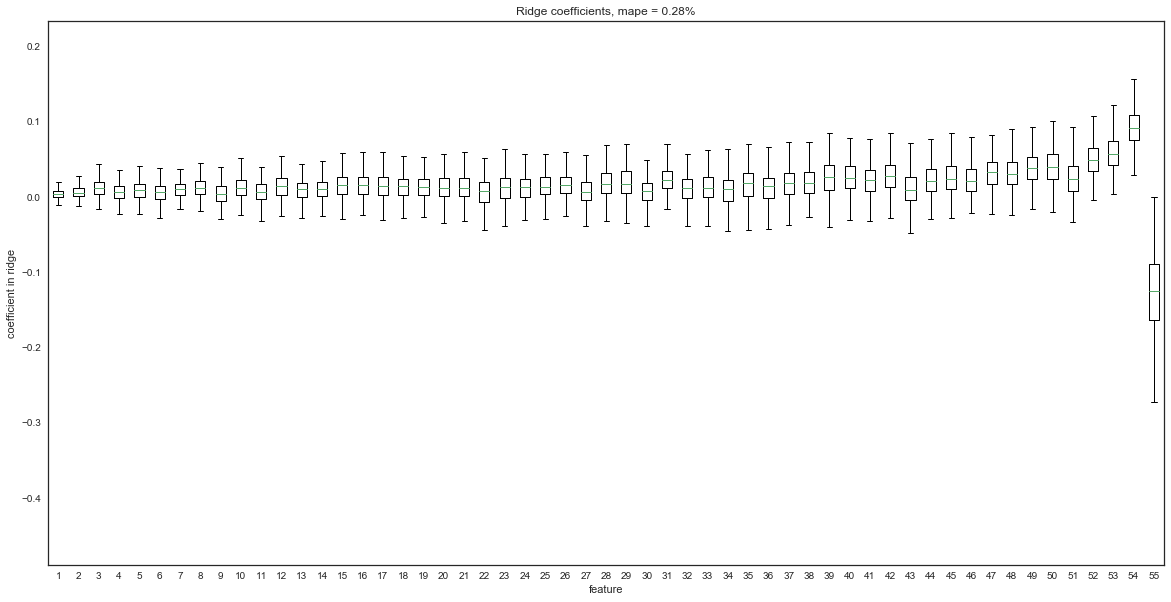

In [77]:
plt.clf()
plt.title("Ridge coefficients, mape = 0.28%")
plt.boxplot(coefs_importances)
plt.ylabel("coefficient in ridge")
plt.xlabel("feature")
plt.show()

# Simple ridge, whole data

In [88]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

copy_data = data_train.copy()
copy_data = copy_data[keys_volatility]

y = target_train["TARGET"].values
    
copy_data = copy_data.fillna(copy_data.median())
    
X = copy_data.values

model = Ridge(alpha = 1.0)

model.fit(X,y)

copy_test = data_test.copy()

copy_test = copy_test.fillna(copy_test.median())

copy_test = copy_test[keys_volatility]

X = copy_test.values

predictions = pd.DataFrame()
predictions["ID"] = data_test["ID"]
predictions["TARGET"] = [np.NaN]*data_test.shape[0]

y_pred = model.predict(X)

predictions["TARGET"] = y_pred

In [89]:
predictions.to_csv("../OriginalData/predictions_1_Ridge.csv",index = False,sep = ";")

# For one date, reshape to have data about all products as features

In [159]:
import re

N_dates = 2117
N_products = 10

data_reshape = pd.DataFrame()

keys_volatility =[]

for key in data_train.keys():
    n = re.split("volatility ",key)
    if len(n) > 1:
        keys_volatility += [key]

for date in range(1,N_dates+1):
    data_date = pd.DataFrame()
    for k in range(1,N_products+1):
        product = k
        for key_vol in keys_volatility:
            key = key_vol+'_'+str(product)
            data_date[key] = [data_train.loc[groups[date]][key_vol].values[product]]
        key = "TARGET_"+str(product)
        data_date[key] = [data_train.loc[groups[date]]["TARGET"].values[product]]
    data_reshape = pd.concat([data_reshape,data_date])

KeyboardInterrupt: 

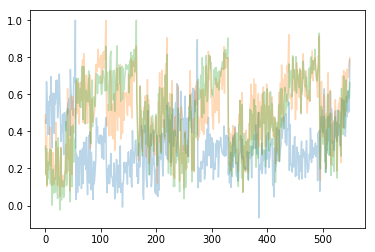

In [158]:
plt.clf()
plt.plot(data_reshape.corr()["TARGET_1"].values, alpha = 0.3)
plt.plot(data_reshape.corr()["TARGET_2"].values, alpha = 0.3)
plt.plot(data_reshape.corr()["TARGET_3"].values,alpha = 0.3)
plt.show()

In [156]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

copy_data = data_reshape.copy()

y = copy_data["TARGET_9"].values

for k in range(1,N_products+1):
    del copy_data["TARGET_"+str(k)]
    
copy_data = copy_data.fillna(copy_data.median())
    
X = copy_data.values

X_train,X_test,y_train,y_test = train_test_split(X,y)

model = Ridge()

model.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [157]:
y_pred = model.predict(X_test)

print(np.mean(np.abs(y_test - y_pred)/y_test))

0.284898550193


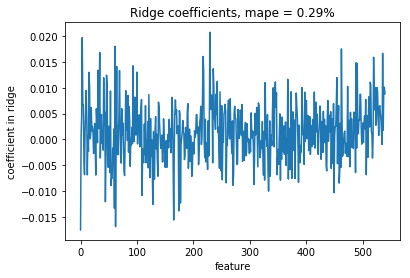

In [108]:
plt.clf()
plt.title("Ridge coefficients, mape = 0.29%")
plt.plot(model.coef_)
plt.ylabel("coefficient in ridge")
plt.xlabel("feature")
plt.show()

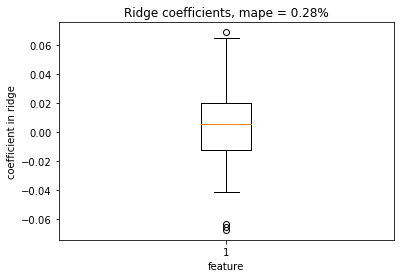

In [71]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

copy_data = data_reshape.copy()

y = copy_data["TARGET_2"].values

for k in range(1,N_products+1):
    del copy_data["TARGET_"+str(k)]
    
copy_data = copy_data.fillna(copy_data.median())
    
X = copy_data.values

X_train,X_test,y_train,y_test = train_test_split(X,y)

model = Ridge()

model.fit(X_train,y_train)

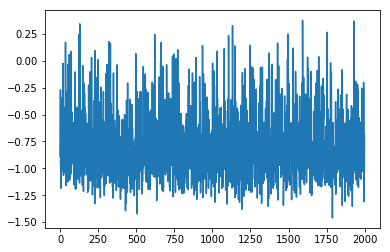

In [100]:
plt.clf()
plt.plot(np.log10(y))
plt.show()